<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/main/Spectral_Clustering/04_Spectral_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 4: Spectral Clustering

## The Algorithm

We have covered a lot of material so far and we finally could combine them together and give a clear picture. Remember, we discover a method from coupled spring system to assign coordinates to data points so that similar data points are closer to each other. Then we introduce briefly the k-means method of clustering for simple problems. Now we could combine them together:

1. Given a set of data, we first get the similarity measurements among them.
2. We embed the data points into a space according to the similarity measure via the clustering embedding.
3. We use k-means to cluster the data.

Note the similarity measure should be dependent on the problems we want to solve and should not be arbitrary. 

We should now assembly the code and finish the algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def GraphLaplacian(K):
    D = np.diag(np.sum(K, axis = 1))
    L = D-K
    return L

def GetNormalMode(K, first_few = 2):
    L = GraphLaplacian(K)
    eigval, eigvec = np.linalg.eig(L)
    order = np.argsort(eigval)
    chosen = order[1:1+first_few] # neglect the 0 eigen value
    
    return eigvec[:, chosen], eigval[chosen]

class KMeans:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        
    def fit(self, data, max_iter = 100, random_seed = None):
        
        if random_seed is not None:
            np.random.RandomState(random_seed)
        assign = [i for i in range(self.n_clusters)]*(data.shape[0]//self.n_clusters)
        assign += list(np.random.choice(np.arange(self.n_clusters), size=data.shape[0] - len(assign)))
        assign = np.array(assign)
        np.random.shuffle(assign)
        
        means = np.zeros(shape=(self.n_clusters, data.shape[1]))
        it = 0
        while it < max_iter:
            it +=1
            for k in range(self.n_clusters):
                #print (np.mean(data[assign == k,:], axis=0).shape)
                means[k,:] = np.mean(data[assign == k,:], axis = 0)
            
            dists = np.sum( (data[:,None, :] - means[None,:,:])**2, axis = -1)
            new_assign = np.argmin(dists, axis = -1)
            if np.sum(new_assign != assign) ==0 :
                break
            assign[:] = new_assign[:]
            
        self.means = means
    
        return self
    
    def predict(self, data):
        
        dists = np.sum( (data[:,None, :] - self.means[None,:,:])**2, axis = -1)
        assign = np.argmin(dists, axis = -1)
        return assign   
    

In the Spectral Clustering function, we first embed the data according to the similarity measure and then fit clustering the data using K-means. 

In [2]:
def SpectralClustering(K, n_clusters, embed_dim = 2, **kwargs):
    coords, _ = GetNormalMode(K, first_few = embed_dim)
    km = KMeans(n_clusters)
    return km.fit(coords, **kwargs).predict(coords)

We could then come back to the example in part 2 and finish the clustering by k-means.First, we get the data 

In [3]:
K = np.zeros((10,10))
# first cluster
for i in range(3):
    for j in range(i+1,3):
        K[i,j] = np.random.uniform(5.0, 10.0)
        K[j,i] = K[i,j]
# second cluster
for i in range(3,8):
    for j in range(i+1,8):
        K[i,j] = np.random.uniform(5.0, 10.0)
        K[j,i] = K[i,j]
        
# second cluster
for i in range(8,10):
    for j in range(i+1,10):
        K[i,j] = np.random.uniform(5.0, 10.0)
        K[j,i] = K[i,j]

np.random.RandomState(2100)
K = K + np.random.uniform(1.0, 3.0, size=(10,10))

Then we test our algorithm for the $10$ data points. We should expect that $1\sim 3$ are from the same cluster, $4-8$ are from the same cluster and $9$, $10$ are in the third cluster.

In [4]:
assignments = SpectralClustering(K, 3, random_seed = 2100)
print (assignments)

[0 0 0 2 2 2 2 2 1 1]


The result agrees with our expectation since we see the first three particles are labeled by the same number, the middle 5 particles are labeled by another number and the last two particles are labeled by a third number.

## Example

In the above example, we are given a similarity measure. In real application, we would normaly be only provided by data points and we should construct similarity measure ourselves. In this example, we consider a simple toy problem. We consider data are clustered on three concentric loops and we want to use our algorithm to cluster them.

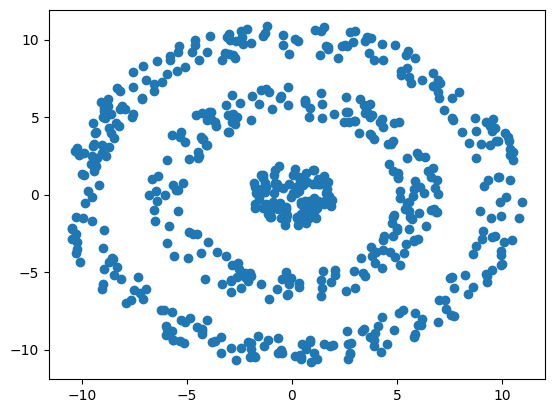

In [5]:
def random_loop(min_radius, max_radius, num):
    r = np.sqrt(2*np.random.uniform(0.5*min_radius**2, 0.5*max_radius**2, num))
    theta = np.random.uniform(0, np.pi*2, num)
    return np.stack([r*np.cos(theta), r*np.sin(theta)],axis = 0).T

np.random.RandomState(2100)
data1 = random_loop(0, 2.0, 100)
data2 = random_loop(5.0, 7.0, 200)
data3 = random_loop(9.0, 11.0, 300)

data = np.concatenate([data1,data2, data3], axis = 0)

plt.scatter(data[:,0], data[:,1])

We could construct the similarity measure according to their distance. In order to put more similarities to points with smaller distance, we could let the similarity to decay exponential with increased distances. That is 

$$
K_{ij} = \exp(- (\mathbf{x}_i-\mathbf{x}_j)^2)
$$

Then we construct K matrix accordingly and we could run the spectral clustering algorithm.

/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/juliehartley/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


<AxesSubplot: >

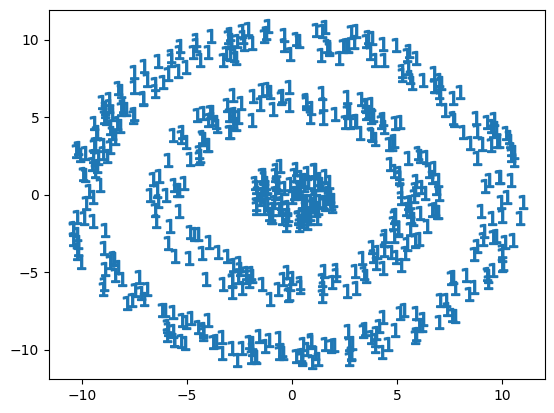

In [6]:
dists = np.sum( (data[:,None,:] - data[None,:,:])**2, axis = -1)
K = np.exp(-dists)

assignments = SpectralClustering(K, 3 , random_seed = 2100)

def plot_clustering(data, assign, ax = None):
    n = np.max(assign)+1
    if ax is None:
        ax = plt.gca()
    for i in range(n):
        ax.scatter(data[assign==i,0], data[assign==i,1], marker=f"${i+1}$", s = 20*5 )
    return ax

plot_clustering(data, assignments)

We see that our algorithm correctly clustered the data points according to our intuition. That is, points from the same loop are clustered to the same cluster. 

## Homework 

### Problem 1

In the concetric loop example, what do you expect to happen if you directly run K-means algorithm on the raw data without spectral embedding? Run the k-means to confirm your guess. 

### Solution:

If we directly run k-means algorithm on the raw data, we cannot get the clear clustering results. This is because the three clusters share the same centroid and in k-means, data are clustered according to their distance to the centroid. We can confirm it by running the algorithm

<AxesSubplot: >

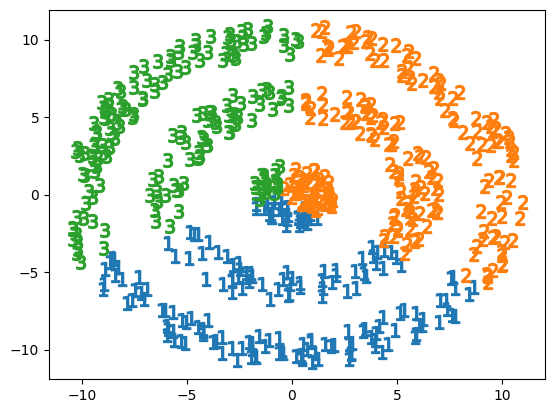

In [7]:
km = KMeans(3)
assign = km.fit(data).predict(data)
plot_clustering(data, assign)